In [12]:
%load_ext autoreload
from coffea import hist, util

import coffea.processor as processor
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
import awkward as ak
import numpy as np
import uproot
import re

from pprint import pprint
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
%autoreload 2
import sys 
import os

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)


In [14]:
from ttgenv.Utils.plotting import plotWithRatio
from ttgenv.Utils.genParentage import maxHistoryPDGID

In [49]:
class PhotonSelector(processor.ProcessorABC):
    def __init__(self, isMC=False):
        # In the initializer, any of the outputs you would like to produce are defined (ex. histograms)
        # Coffea histograms are defined in the same way as in the previous exercise
        # define a list of axes first
        #Declare axis
        dataset_axis = hist.Cat("dataset","Dataset")
        
        ## Define axis to keep track of photon category
        phoCategory_axis = hist.Bin("category", r"Photon Category", [1,2,3,4,5])
        phoCategory_axis.identifiers()[0].label = "Genuine Photon"    
        phoCategory_axis.identifiers()[1].label = "Misidentified Electron"    
        phoCategory_axis.identifiers()[2].label = "Hadronic Photon"    
        phoCategory_axis.identifiers()[3].label = "Hadronic Fake"    
        
        #Declare axis 
        #m3_axis = hist.Bin("M3", r"$M_3$ [GeV]", 40, 0., 1000)
        mass_axis = hist.Bin("mass", r"$m_{\ell\gamma}$ [GeV]", 40, -10., 10)
        pt_axis = hist.Bin("pt", r"$p_{T}$ [GeV]", 40, 0., 400)
        eta_axis = hist.Bin("eta", r"$\eta_{\gamma}$", 50, -2.5, 2.5)
        #chIso_axis = hist.Bin("chIso", r"Charged Hadron Isolation", np.arange(-0.1,20.001,.05))
        
        relIso_axis=hist.Bin("relIso", "relIso", 50,-4.5,4.5)
        phi_axis = hist.Bin("phi","$\phi$", 64, -3.2, 3.2)
        
        
        #Define the accumulator object, a dictionary storing all of the histograms and counters 
        #that we will fill later in the process function
        self.isMC = isMC

        self._accumulator = processor.dict_accumulator({
            'photon_pt': hist.Hist("Counts", dataset_axis, pt_axis, phoCategory_axis),
            'photon_eta': hist.Hist("Counts", dataset_axis, eta_axis),
            'photon_phi': hist.Hist("Counts", dataset_axis, phi_axis),
            'photon_mass': hist.Hist("Counts", dataset_axis, mass_axis),
            
            'tight_photon_pt': hist.Hist("Counts", dataset_axis, pt_axis),
            'tight_photon_eta': hist.Hist("Counts", dataset_axis, eta_axis),
            'tight_photon_phi': hist.Hist("Counts", dataset_axis, phi_axis),
            'tight_photon_mass': hist.Hist("Counts", dataset_axis, mass_axis),
        
            
            'charge':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'cleanmask':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'cutBased':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'cutBased17Bitmap':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'eCorr':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'electronIdx':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'electronIdxG':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'electronVeto':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'energyErr':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'genPartFlav':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'genPartIdx':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'genPartIdxG':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'hoe':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'isScEtaEB':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'isScEtaEE':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'jetIdx':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'jetIdxG':processor.column_accumulator(np.ndarray(shape=(1,8))),
           # 'mass':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID17':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID17_WP80':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID17_WP90':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID_WP80':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'mvaID_WP90':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'pdgId':processor.column_accumulator(np.ndarray(shape=(1,8))),
            
            'pfRelIso03_all':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'pfRelIso03_chg':processor.column_accumulator(np.ndarray(shape=(1,8))),
            
            'pixelSeed':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'r9':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'seedGain':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'sieie':processor.column_accumulator(np.ndarray(shape=(1,8))),
            'vidNestedWPBitmap':processor.column_accumulator(np.ndarray(shape=(1,8))),
          
            
            
            'EventCount': processor.value_accumulator(int),

        }
        )
        

    @property
    def accumulator(self):
        return self._accumulator

    

    # The process method is where the heart of the analysis is.  
    # This is where all of the selections are done and the histograms get filled 
    #  (things you did in notebook cells before will be done here instead)
    def process(self, events):
        ### The process function is where most of the work happens. As we'll see below, this is
        ### where the main analysis work happens (object cuts, event selections, filling histograms). 
        
        output = self.accumulator.identity()
        output['EventCount'] = len(events)

        dataset = events.metadata['dataset']
        
        if self.isMC:
            idx = ak.to_numpy(ak.flatten(abs(events.GenPart.pdgId)))
            par = ak.to_numpy(ak.flatten(events.GenPart.genPartIdxMother))
            num = ak.to_numpy(ak.num(events.GenPart.pdgId))        
            maxParentFlatten = maxHistoryPDGID(idx,par,num)
            events["GenPart","maxParent"] = ak.unflatten(maxParentFlatten, num)

        
        ######################
        ###OverlapREMOVAL#####
        ######################
        
        doOverlapRemoval = False
        if 'TTbar' in dataset:
            doOverlapRemoval = True
            overlapPt = 10.
            overlapEta = 5.
            overlapDR = 0.1
        if re.search("^W+[1234]jets$", dataset):
            doOverlapRemoval = True
            overlapPt = 10.
            overlapEta = 2.5
            overlapDR = 0.05


            
        if doOverlapRemoval:
            genmotherIdx = events.GenPart.genPartIdxMother
            genpdgid = events.GenPart.pdgId

            #potential overlap photons are only those passing the kinematic cuts 
            overlapPhoSelect = ((events.GenPart.pt>=overlapPt) & 
                                (abs(events.GenPart.eta) < overlapEta) & 
                                (events.GenPart.pdgId==22) & 
                                (events.GenPart.status==1) & 
                                (events.GenPart.maxParent < 37)
                               )
            overlapPhotons = events.GenPart[overlapPhoSelect] 

            #also require that photons are separate from all other gen particles
            finalGen = events.GenPart[((events.GenPart.status==1)|(events.GenPart.status==71)) & (events.GenPart.pt > 0.01) &
                                      ~((abs(events.GenPart.pdgId)==12) | (abs(events.GenPart.pdgId)==14) | (abs(events.GenPart.pdgId)==16)) &
                                      ~overlapPhoSelect]

            #calculate dR between overlap photons and nearest gen particle
            phoGen, phoGenDR = overlapPhotons.nearest(finalGen, return_metric = True)
            phoGenMask = ak.fill_none(phoGenDR > overlapDR, True)

            #the event is overlapping with the separate sample if there is an overlap photon passing the dR cut, kinematic cuts, and not coming from hadronic activity
            isOverlap = ak.any(phoGenMask, axis=-1)
            passOverlapRemoval = ~isOverlap

        else:
            passOverlapRemoval = np.ones_like(len(events))==1
        
        
        ######################
        ###Object Selection###
        ######################
        
        #Add Tight Muon Select
        muons=events.Muon
        muonSelectTight = ((muons.pt>30) &
                           (abs(muons.eta)<2.4) &
                           (muons.tightId) &
                           (muons.pfRelIso04_all < 0.15)
                          )
        #Add Jet Select
        jets=events.Jet
        jetSelectTight = ((jets.pt>30) &
                          (abs(jets.eta)<2.4) &
                          (jets.isTight)
                         )

        #Add b-tagged Jet Select
        btaggedJetSelect = (jetSelectTight &
                           (jets.btagDeepB>0.6321)
                          )
        
        #Add Electron Select
        electrons=events.Electron
        electronSelectTight = ((electrons.pt> 35) &
                           (abs(electrons.eta)<2.1) &
                            electrons.cutBased>=4   
                         )
        #Add Photon Select
        photon=events.Photon
        photonSelect= ((photon.pt>20) & 
                        (abs(photon.eta) < 1.4442) &
                        (photon.isScEtaEE | photon.isScEtaEB) &
                        (photon.electronVeto) & 
                        np.invert(photon.pixelSeed) 
                       )
        photonID= photon.cutBased >=2
        #Apply Selection
        tightMuons = muons[muonSelectTight]
        tightJets = jets[jetSelectTight]
        tightBJets = jets[btaggedJetSelect]
        photons = photon[photonSelect]
        tightPho =photon[(photonID & photonSelect)]
        tightEle = electrons[electronSelectTight]
        
        #####################
        ###Event Selection###
        #####################
        
        #Apply trigger and add event selection 
        trigger = events.HLT.IsoMu24 | events.HLT.IsoTkMu24
        
        one_muon=(ak.num(tightMuons)==1)
        four_jets=(ak.num(tightJets)>=4)
        btag_jet=(ak.num(tightBJets)>=1)
        zero_ele=(ak.num(tightEle)==0)
        one_photon=(ak.num(tightPho)==1)
        
        # Select events passing the trigger, with exactly one tight muon, one tight photon, no electrons,  ≥4 jets, and ≥ 1 b-tagged jets. 
        eventSelection = (trigger &
                          one_muon &
                          four_jets & 
                          btag_jet &
                          one_photon &
                          zero_ele)
        
        #E=events[eventSelection]
        leading_pho=tightPho[:,:1]
        #Photon=leading_pho[eventSelection]
    
        #####################
        ###Photon Category###
        #####################
        
            
        # Define photon category for each event
        phoCategory = np.ones(len(events))
        
        if self.isMC:
            matchedPho = ak.any(leading_pho.matched_gen.pdgId==22, axis=-1)
            matchedEle =  ak.any(abs(leading_pho.matched_gen.pdgId)==11, axis=-1)
            hadronicParent = ak.any(leading_pho.matched_gen.maxParent>25, axis=-1)
            
            isGenPho = matchedPho & ~hadronicParent
            isHadPho = matchedPho & hadronicParent
            isMisIDele = matchedEle
            isHadFake =  ~(isMisIDele | isGenPho | isHadPho) & (ak.num(leading_pho)==1)

            #define integer definition for the photon category axis 
            phoCategory = 1*isGenPho + 2*isMisIDele + 3*isHadPho + 4*isHadFake
        
    
        ##Fill Histograms
        
        
        output['photon_pt'].fill(dataset=dataset,pt=ak.flatten(photons.pt[:,:1][eventSelection]), category=phoCategory[eventSelection],) 
        output['photon_eta'].fill(dataset=dataset,eta=ak.flatten(photons.eta[:,:1][eventSelection])) 
        output['photon_mass'].fill(dataset=dataset,mass=ak.flatten(photons.mass[:,:1][eventSelection])) 
        output['photon_phi'].fill(dataset=dataset,phi=ak.flatten(photons.phi[:,:1][eventSelection])) 
        
        output['tight_photon_pt'].fill(dataset=dataset,pt=ak.flatten(tightPho.pt[:,:1][eventSelection])) 
        output['tight_photon_eta'].fill(dataset=dataset,eta=ak.flatten(tightPho.eta[:,:1][eventSelection])) 
        output['tight_photon_mass'].fill(dataset=dataset,mass=ak.flatten(tightPho.mass[:,:1][eventSelection])) 
        output['tight_photon_phi'].fill(dataset=dataset,phi=ak.flatten(tightPho.phi[:,:1][eventSelection])) 
        
        return output
        '''  
        charge=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.charge[:,:1][eventSelection],8,clip=True))))
        output['charge']+=charge
        
        
        cleanmask=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cleanmask[:,:1][eventSelection],8,clip=True))))
        output['cleanmask']+=cleanmask

        
        cutBased=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cutBased[:,:1][eventSelection],8,clip=True))))
        output['cutBased']+=cutBased

        
        cutBased17Bitmap=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.cutBased17Bitmap[:,:1][eventSelection],8,clip=True))))
        output['cutBased17Bitmap']+=cutBased17Bitmap

        
        eCorr=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.eCorr[:,:1][eventSelection],8,clip=True))))
        output['eCorr']+=eCorr
    
        
        electronIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronIdx[:,:1][eventSelection],8,clip=True))))
        output['electronIdx']+=electronIdx

        
        electronIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronIdxG[:,:1][eventSelection],8,clip=True))))
        output['electronIdxG']+=electronIdxG

        
        electronVeto=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.electronVeto[:,:1][eventSelection],8,clip=True))))
        output['electronVeto']+=electronVeto

        
        energyErr=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.energyErr[:,:1][eventSelection],8,clip=True))))
        output['energyErr']+=energyErr

        if self.isMC:
            
            genPartFlav=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartFlav[:,:1][eventSelection],8,clip=True))))
            output['genPartFlav']+=genPartFlav

        
            genPartIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartIdx[:,:1][eventSelection],8,clip=True))))
            output['genPartIdx']+=genPartIdx

        
            genPartIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.genPartIdxG[:,:1][eventSelection],8,clip=True))))
            output['genPartIdxG']+=genPartIdxG

        
        hoe=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.hoe[:,:1][eventSelection],8,clip=True))))
        output['hoe']+=hoe

        
        isScEtaEB=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.isScEtaEB[:,:1][eventSelection],8,clip=True))))
        output['isScEtaEB']+=isScEtaEB

        
        isScEtaEE=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.isScEtaEE[:,:1][eventSelection],8,clip=True))))
        output['isScEtaEE']+=isScEtaEE

        
        jetIdx=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.jetIdx[:,:1][eventSelection],8,clip=True))))
        output['jetIdx']+=jetIdx

        
        jetIdxG=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.jetIdxG[:,:1][eventSelection],8,clip=True))))
        output['jetIdxG']+=jetIdxG

        
        mvaID=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID[:,:1][eventSelection],8,clip=True))))
        output['mvaID']+=mvaID

        
        mvaID17=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17[:,:1][eventSelection],8,clip=True))))
        output['mvaID17']+=mvaID17

        
        mvaID17_WP80=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17_WP80[:,:1][eventSelection],8,clip=True))))
        output['mvaID17_WP80']+=mvaID17_WP80

        
        mvaID17_WP90=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID17_WP90[:,:1][eventSelection],8,clip=True))))
        output['mvaID17_WP90']+=mvaID17_WP90

        
        mvaID_WP80=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID_WP80[:,:1][eventSelection],8,clip=True))))
        output['mvaID_WP80']+=mvaID_WP80

        
        mvaID_WP90=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.mvaID_WP90[:,:1][eventSelection],8,clip=True))))
        output['mvaID_WP90']+=mvaID_WP90

        
        pdgId=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pdgId[:,:1][eventSelection],8,clip=True))))
        output['pdgId']+=pdgId

            
        pfRelIso03_all=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pfRelIso03_all[:,:1][eventSelection],8,clip=True))))
        output['pfRelIso03_all']+=pfRelIso03_all

        
        pfRelIso03_chg=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pfRelIso03_chg[:,:1][eventSelection],8,clip=True))))
        output['pfRelIso03_chg']+=pfRelIso03_chg
   
        pixelSeed=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.pixelSeed[:,:1][eventSelection],8,clip=True))))
        output['pixelSeed']+=pixelSeed

        
        r9=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.r9[:,:1][eventSelection],8,clip=True))))
        output['r9']+=r9

        
        seedGain=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.seedGain[:,:1][eventSelection],8,clip=True))))
        output['seedGain']+=seedGain

        
        sieie=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.sieie[:,:1][eventSelection],8,clip=True))))
        output['sieie']+=sieie

        
        vidNestedWPBitmap=processor.column_accumulator(np.array(ak.to_numpy(ak.pad_none(tightPho.vidNestedWPBitmap[:,:1][eventSelection],8,clip=True)))) 
        output['vidNestedWPBitmap']+=vidNestedWPBitmap
        
        
        return output
'''
    def postprocess(self, accumulator):
        return accumulator

In [50]:
#Define files to run over
skimDir="root://cmseos.fnal.gov//store/user/lpctop/TTGamma_FullRun2/Skims_v6-2/2016/"

fileset = {"TTGamma":[f"{skimDir}/TTGamma_SingleLept_2016_skim.root"],
           "TTbar":[f"{skimDir}/TTbarPowheg_Semilept_2016_skim_1of10.root",
                    f"{skimDir}/TTbarPowheg_Semilept_2016_skim_2of10.root"],
           "WGamma":[f"{skimDir}/WGamma_2016_skim.root"],
           "Z+jets":[f'{skimDir}/DYjetsM50_ext2_2016_skim_1of10.root'],
           "W+3jets":[f"{skimDir}/W3jets_2016_skim.root"],
           "W+4jets":[f"{skimDir}/W4jets_2016_skim.root"],
          }

filesetData = {"DataMu":[f"{skimDir}/Data_SingleMu_b_2016_skim_1of10.root"],
              }

In [51]:
np.warnings.filterwarnings('ignore')

#the NanoAODSchema needs to be adjusted, to remove cross references to FSRPhotons
class SkimmedSchema(NanoAODSchema):
    def __init__(self, base_form):
        base_form["contents"].pop("Muon_fsrPhotonIdx", None)
        super().__init__(base_form)

#Run Coffea code using uproot
outputMC = processor.run_uproot_job(
    fileset,  #dictionary of datasets to run on, defined earlier in this cell
    "Events", #Name of the TTree you will be opening
    PhotonSelector(isMC=True),  #Coffea processor you defined
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4},  ## workers = 2, parallelize jobs, running 2 at once
    chunksize=1000000, #in each chunk, use 1 million events
#     maxchunks=3, #limit to using only 3 chunks for each dataset (useful for testing purposes)
)

Processing:   0%|          | 0/23 [00:00<?, ?chunk/s]

In [7]:
#outputMC

In [52]:
outputData = processor.run_uproot_job(
    filesetData,
    "Events",
    PhotonSelector(),
    processor.futures_executor,
    executor_args={"schema": SkimmedSchema,'workers': 4}, 
    chunksize=1000000,
)


Processing:   0%|          | 0/6 [00:00<?, ?chunk/s]

In [53]:
nEvents = {}
for d in fileset:
    if not d in nEvents:
        nEvents[d] = 0
    for fName in fileset[d]:
        with uproot.open(fName)['hEvents'] as hEvents:
            nEvents[d] += hEvents.values()[0] + hEvents.values()[2]
cx = {'TTGamma':7.509,
     'TTbar': 380.095,
     'WGamma':489,
     'Z+jets':6077.22,
     'W+3jets':1165.8108,
     'W+4jets':592.9176}
lumi_weight = {}
for keyName in fileset:
    lumi_weight[keyName] = (cx[keyName]*578.)/nEvents[keyName] #578
    
for key, obj in outputMC.items():
    if isinstance(obj, hist.Hist):
        obj.scale(lumi_weight, axis="dataset")    
            

In [54]:
data_err_opts = {
    'linestyle':'none',
    'marker': '.',
    'markersize': 10.,
    'color':'k',
    'elinewidth': 1,
}

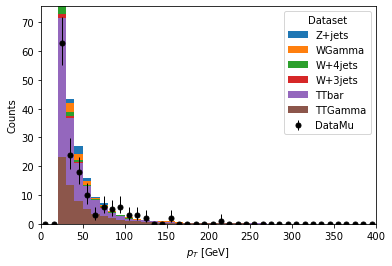

In [55]:
hist.plot1d(outputData['tight_photon_pt'],overlay='dataset',error_opts=data_err_opts)
hist.plot1d(outputMC['tight_photon_pt'],overlay='dataset',stack=True)


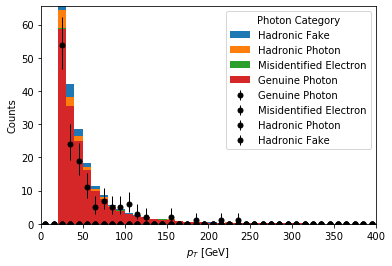

In [58]:
hist.plot1d(outputData['photon_pt'].sum('dataset'),overlay='category',error_opts=data_err_opts)
hist.plot1d(outputMC['photon_pt'].sum('dataset'),overlay='category',stack=True)

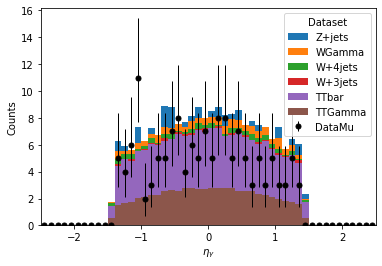

In [59]:
hist.plot1d(outputData['photon_eta'],overlay='dataset',error_opts=data_err_opts)
hist.plot1d(outputMC['photon_eta'],overlay='dataset',stack=True)

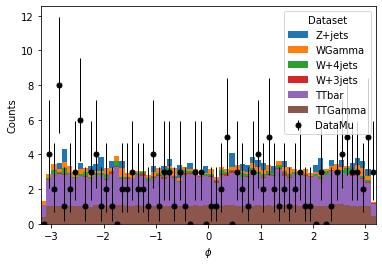

In [60]:
hist.plot1d(outputData['photon_phi'],overlay='dataset',error_opts=data_err_opts)
hist.plot1d(outputMC['photon_phi'],overlay='dataset',stack=True)

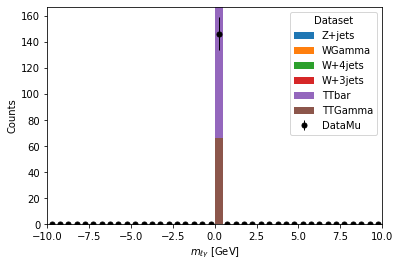

In [61]:
hist.plot1d(outputData['photon_mass'],overlay='dataset',error_opts=data_err_opts)
hist.plot1d(outputMC['photon_mass'],overlay='dataset',stack=True)